## Imbalance Pricing Insights

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Preprocessing

In [ ]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data.fillna(method='ffill', inplace=True)
    data['SettlementDate'] = pd.to_datetime(data['SettlementDate'])
    data['StartTime'] = pd.to_datetime(data['StartTime'])
    data.set_index('StartTime', inplace=True)
    data = data.sort_index()
    return data

train_test_files = [
    'train_1.csv',
    'test_1.csv'
]

test_1 = train_test_files[1]
test_1_df = pd.read_csv(test_1)

print(test_1_df.head())

  SettlementDate  SettlementPeriod             StartTime  \
0     2024-02-01                34  2024-02-01T16:30:00Z   
1     2024-02-01                35  2024-02-01T17:00:00Z   
2     2024-02-01                36  2024-02-01T17:30:00Z   
3     2024-02-01                37  2024-02-01T18:00:00Z   
4     2024-02-01                38  2024-02-01T18:30:00Z   

        CreatedDateTime  SystemSellPrice  SystemBuyPrice  BsadDefaulted  \
0  2024-02-02T17:14:26Z            93.72           93.72          False   
1  2024-02-02T17:44:26Z            96.90           96.90          False   
2  2024-02-02T18:14:24Z            96.90           96.90          False   
3  2024-02-02T18:44:28Z            84.02           84.02          False   
4  2024-02-02T19:14:49Z            82.45           82.45          False   

  PriceDerivationCode  ReserveScarcityPrice  NetImbalanceVolume  ...  \
0                   P                   0.0          215.915877  ...   
1                   P                   0.0 

## Analysis

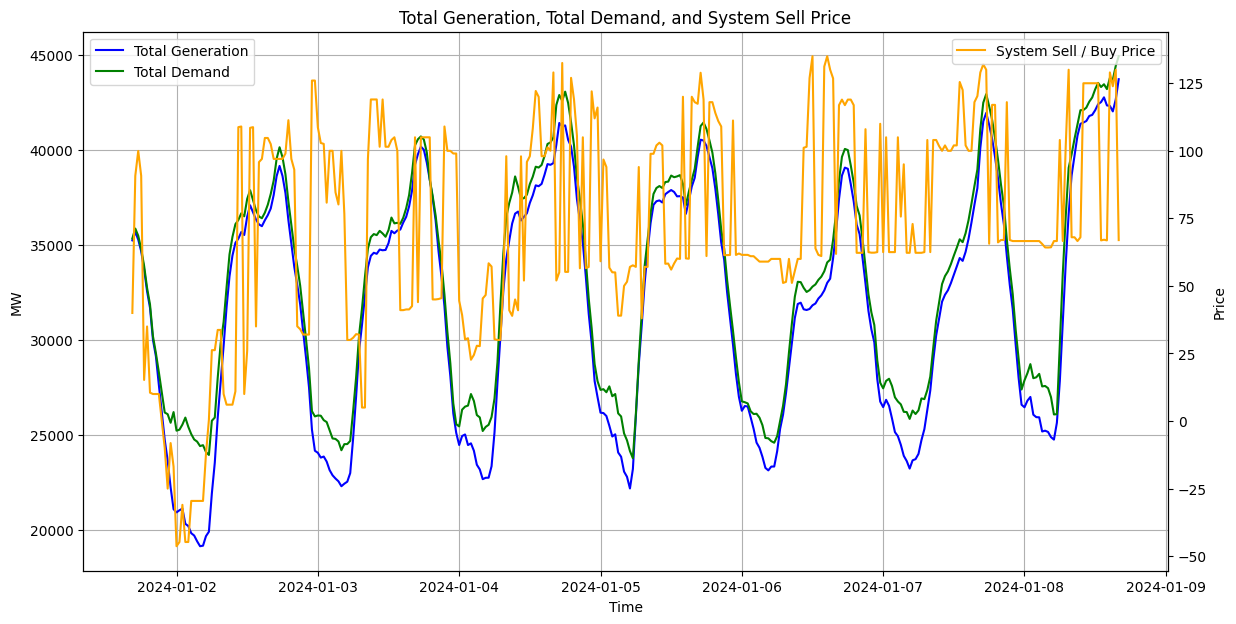

In [ ]:
generation_df = pd.read_csv('GenerationByFuelType.csv')
demand_df = pd.read_csv('RollingSystemDemand.csv')
prices_df = pd.read_csv('SystemSellAndBuyPrices.csv')

generation_df['StartTime'] = pd.to_datetime(generation_df['StartTime'])
demand_df['StartTime'] = pd.to_datetime(demand_df['StartTime'])
prices_df['StartTime'] = pd.to_datetime(prices_df['StartTime'])

total_generation = generation_df.groupby('StartTime')['Generation'].sum().reset_index()

merged_df = pd.merge(total_generation, demand_df, on='StartTime', how='inner')

final_df = pd.merge(merged_df, prices_df[['StartTime', 'SystemSellPrice', 'SystemBuyPrice']], on='StartTime', how='inner')

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(final_df['StartTime'], final_df['Generation'], label='Total Generation', color='b')
ax1.plot(final_df['StartTime'], final_df['Demand'], label='Total Demand', color='g')
ax1.set_xlabel('Time')
ax1.set_ylabel('MW')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(final_df['StartTime'], final_df['SystemSellPrice'], label='System Sell / Buy Price', color='orange')
ax2.set_ylabel('Price')
ax2.legend(loc='upper right')

plt.title('Total Generation, Total Demand, and System Sell Price')
plt.show()

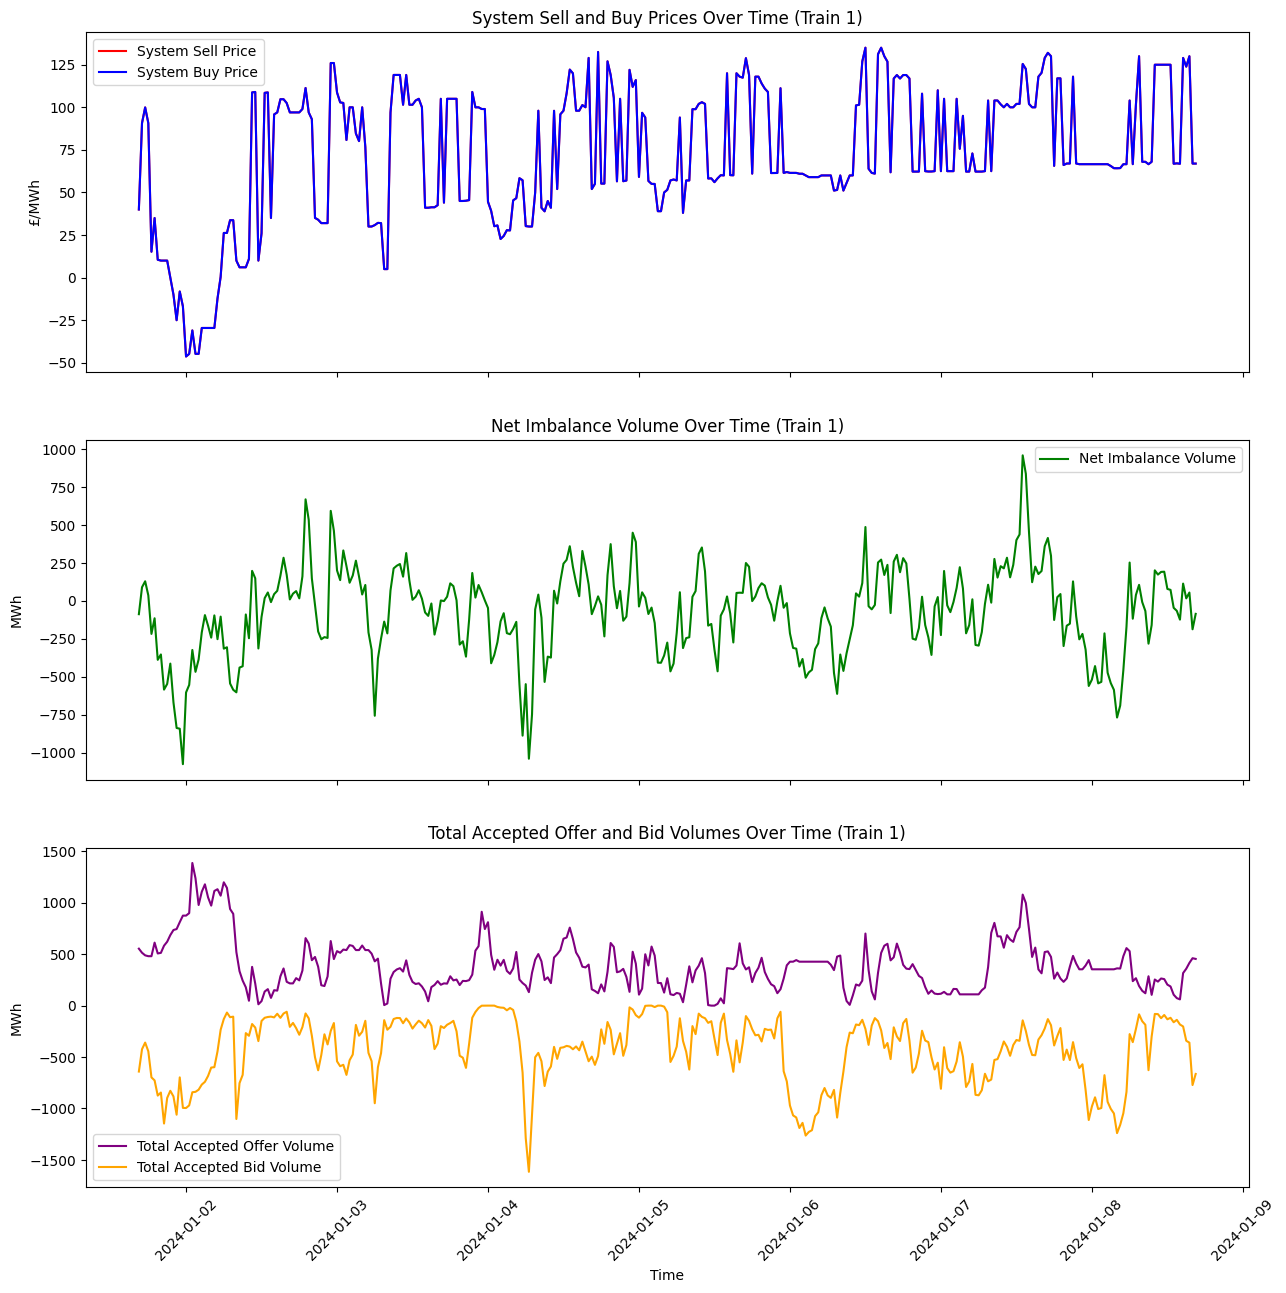

In [ ]:
train_1_df = pd.read_csv("train_1.csv")

train_1_df['SettlementDate'] = pd.to_datetime(train_1_df['SettlementDate'])
train_1_df['StartTime'] = pd.to_datetime(train_1_df['StartTime'])

fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

axs[0].plot(train_1_df['StartTime'], train_1_df['SystemSellPrice'], label='System Sell Price', color='red')
axs[0].plot(train_1_df['StartTime'], train_1_df['SystemBuyPrice'], label='System Buy Price', color='blue')
axs[0].set_title('System Sell and Buy Prices Over Time (Train 1)')
axs[0].set_ylabel('£/MWh')
axs[0].legend()

axs[1].plot(train_1_df['StartTime'], train_1_df['NetImbalanceVolume'], label='Net Imbalance Volume', color='green')
axs[1].set_title('Net Imbalance Volume Over Time (Train 1)')
axs[1].set_ylabel('MWh')
axs[1].legend()

axs[2].plot(train_1_df['StartTime'], train_1_df['TotalAcceptedOfferVolume'], label='Total Accepted Offer Volume', color='purple')
axs[2].plot(train_1_df['StartTime'], train_1_df['TotalAcceptedBidVolume'], label='Total Accepted Bid Volume', color='orange')
axs[2].set_title('Total Accepted Offer and Bid Volumes Over Time (Train 1)')
axs[2].set_ylabel('MWh')
axs[2].legend()

axs[2].set_xlabel('Time')

plt.xticks(rotation=45)
plt.show()

## Model Training - Price

In [ ]:
all_train_data = pd.concat([load_and_preprocess_data(file) for file in train_test_files])

test_file_path = 'test_1.csv'
test_data = load_and_preprocess_data(test_file_path)

train_price_data = all_train_data[['SystemSellPrice']].values
test_price_data = test_data[['SystemSellPrice']].values

train_series = pd.Series(train_price_data.flatten(), index=all_train_data.index)
test_series = pd.Series(test_price_data.flatten(), index=test_data.index)

combined_price_data = np.concatenate((train_price_data, test_price_data), axis=0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_price_data)

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=50))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X, y, batch_size=32, epochs=50)

Epoch 1/50
32/32 [==============================] - 10s 52ms/step - loss: 0.0679
Epoch 2/50
32/32 [==============================] - 1s 45ms/step - loss: 0.0349
Epoch 3/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0318
Epoch 4/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0328
Epoch 5/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0330
Epoch 6/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0308
Epoch 7/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0299
Epoch 8/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0299
Epoch 9/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0295
Epoch 10/50
32/32 [==============================] - 2s 47ms/step - loss: 0.0282
Epoch 11/50
32/32 [==============================] - 1s 33ms/step - loss: 0.0279
Epoch 12/50
32/32 [==============================] - 2s 52ms/step - loss: 0.0266
Epoch 13/50
32/32 [=================

## Model Evaluation - Price

11/11 [==============================] - 2s 18ms/step
MSE: 829.3028990579168
RMSE: 28.797619676944077
MAE: 21.536689606757065
R2 Score: 0.37279053178076926


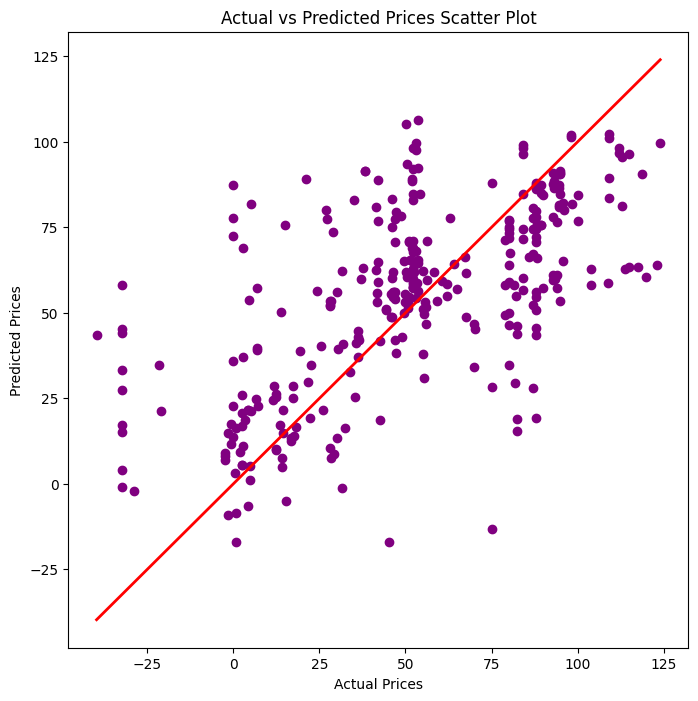

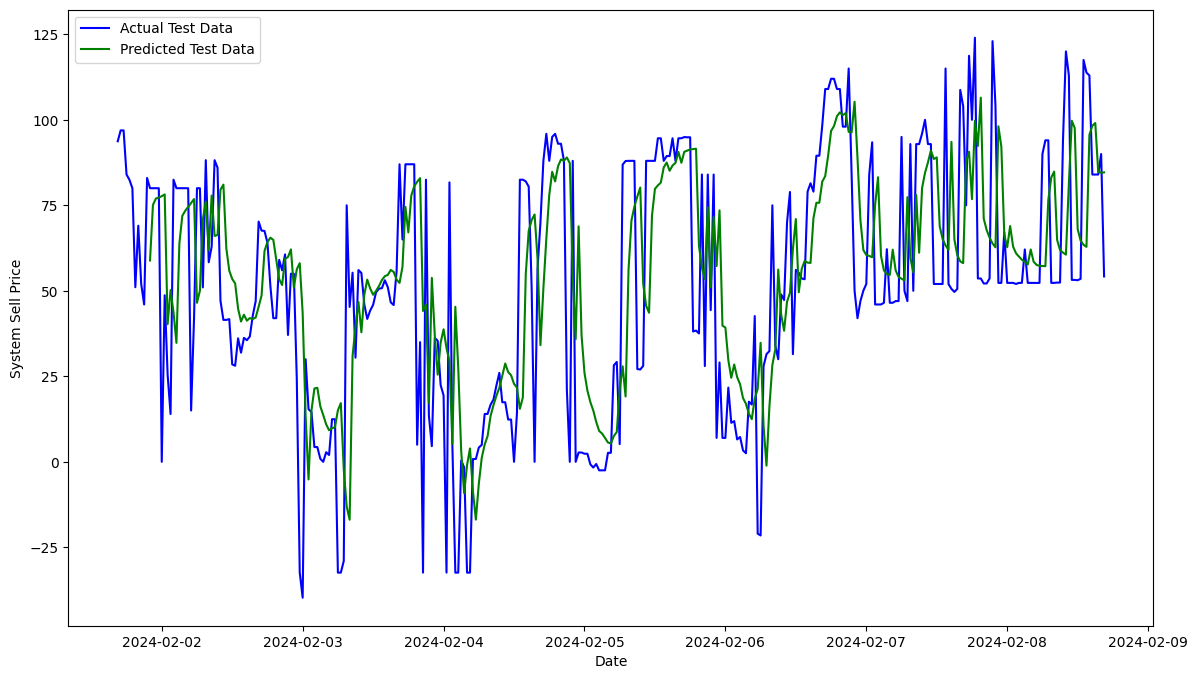

In [ ]:
test_scaled_data = scaler.transform(test_price_data)
X_test, y_test = create_dataset(test_scaled_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

test_series_adjusted = test_series[time_step + 1:]

test_predictions = lstm_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

mse = mean_squared_error(test_series_adjusted, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_series_adjusted, test_predictions)
r2 = r2_score(test_series_adjusted, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

test_predictions_df = pd.DataFrame(test_predictions, index=test_series_adjusted.index, columns=['Predicted Price'])

plt.figure(figsize=(8, 8))
plt.scatter(test_series_adjusted, test_predictions, color='purple')
plt.plot([test_series_adjusted.min(), test_series_adjusted.max()], [test_series_adjusted.min(), test_series_adjusted.max()], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices Scatter Plot')
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(test_predictions_df.index, test_predictions_df['Predicted Price'], label='Predicted Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('System Sell Price')
plt.legend()
plt.show()

## Model Training - Accepted Offer Volume

In [ ]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data.fillna(method='ffill', inplace=True)
    data['SettlementDate'] = pd.to_datetime(data['SettlementDate'])
    data['StartTime'] = pd.to_datetime(data['StartTime'])
    data.set_index('StartTime', inplace=True)
    data = data.sort_index()
    return data

all_train_data = pd.concat([load_and_preprocess_data(file) for file in train_test_files])

test_file_path = 'test_1.csv'
test_data = load_and_preprocess_data(test_file_path)

train_volume_data = all_train_data[['TotalAcceptedOfferVolume']].values
test_volume_data = test_data[['TotalAcceptedOfferVolume']].values

combined_volume_data = np.concatenate((train_volume_data, test_volume_data), axis=0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_volume_data)

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=50))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X, y, batch_size=32, epochs=50)

Epoch 1/50
32/32 [==============================] - 8s 31ms/step - loss: 0.0291
Epoch 2/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0147
Epoch 3/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0134
Epoch 4/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0132
Epoch 5/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0120
Epoch 6/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0113
Epoch 7/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0097
Epoch 8/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0099
Epoch 9/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0082
Epoch 10/50
32/32 [==============================] - 1s 38ms/step - loss: 0.0078
Epoch 11/50
32/32 [==============================] - 2s 50ms/step - loss: 0.0075
Epoch 12/50
32/32 [==============================] - 2s 51ms/step - loss: 0.0075
Epoch 13/50
32/32 [==================

## Model Evaluation - Volume

11/11 [==============================] - 2s 12ms/step
MSE: 47950.794343537
RMSE: 218.97669817479897
MAE: 166.25949118523096
R2 Score: 0.8393065956854101


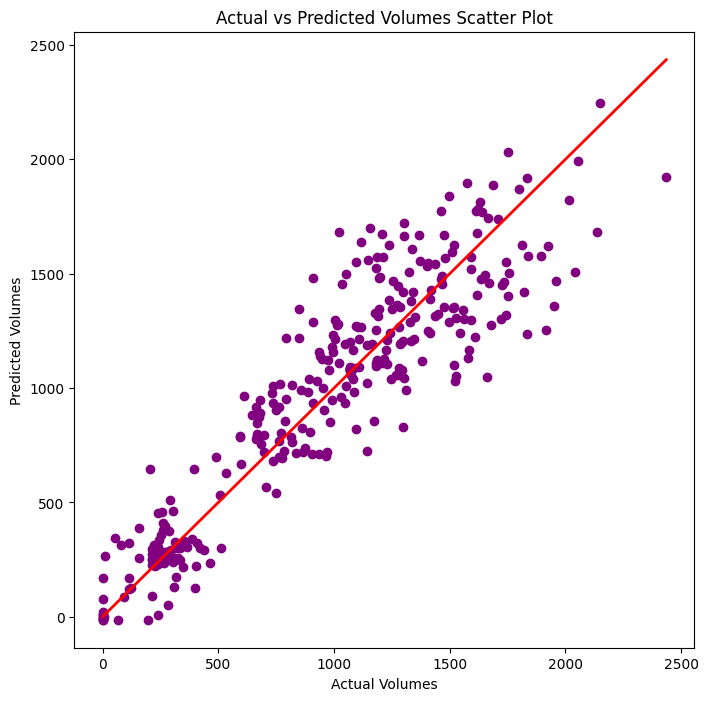

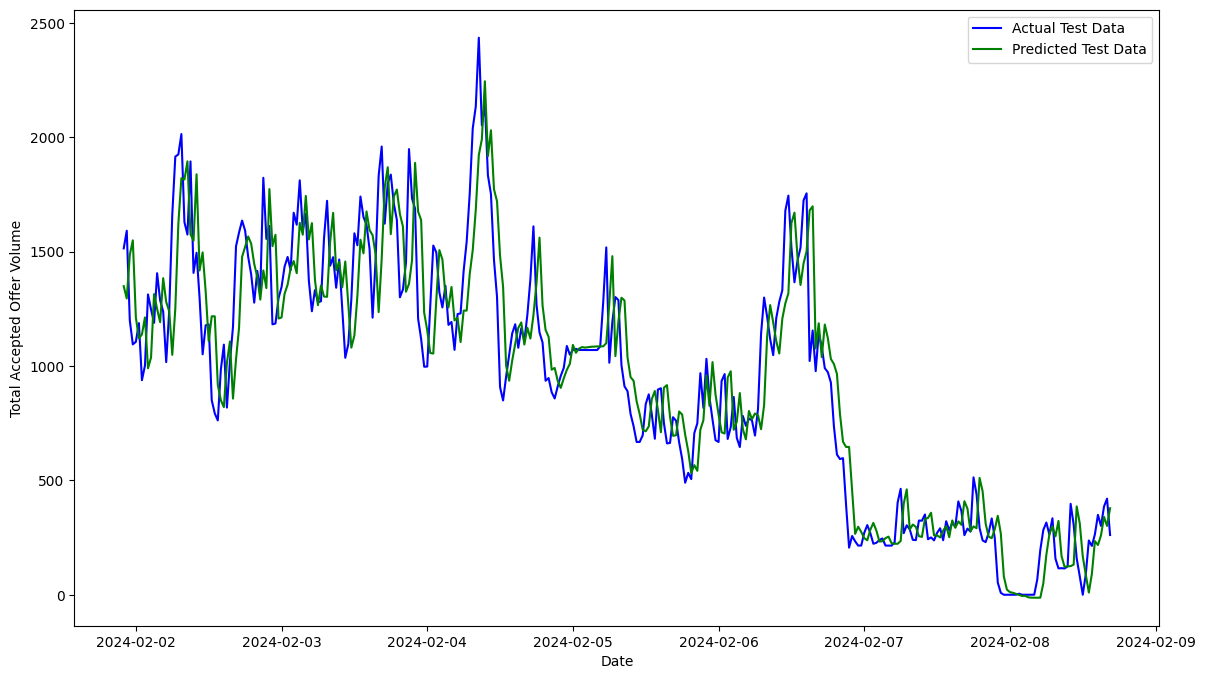

In [ ]:
test_scaled_data = scaler.transform(test_volume_data)
X_test, y_test = create_dataset(test_scaled_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

test_predictions = lstm_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

test_series_adjusted = test_data['TotalAcceptedOfferVolume'][time_step + 1:]

mse = mean_squared_error(test_series_adjusted, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_series_adjusted, test_predictions)
r2 = r2_score(test_series_adjusted, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

test_predictions_df = pd.DataFrame(test_predictions, index=test_series_adjusted.index, columns=['Predicted Volume'])

plt.figure(figsize=(8, 8))
plt.scatter(test_series_adjusted, test_predictions, color='purple')
plt.plot([test_series_adjusted.min(), test_series_adjusted.max()], [test_series_adjusted.min(), test_series_adjusted.max()], color='red', linewidth=2)
plt.xlabel('Actual Volumes')
plt.ylabel('Predicted Volumes')
plt.title('Actual vs Predicted Volumes Scatter Plot')
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(test_series_adjusted.index, test_series_adjusted, label='Actual Test Data', color='blue')
plt.plot(test_predictions_df.index, test_predictions_df['Predicted Volume'], label='Predicted Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('Total Accepted Offer Volume')
plt.legend()
plt.show()

## Model Training - Net Imbalance Volume

In [ ]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data.fillna(method='ffill', inplace=True)
    data['SettlementDate'] = pd.to_datetime(data['SettlementDate'])
    data['StartTime'] = pd.to_datetime(data['StartTime'])
    data.set_index('StartTime', inplace=True)
    data = data.sort_index()
    return data

all_train_data = pd.concat([load_and_preprocess_data(file) for file in train_test_files])

test_file_path = 'test_1.csv'
test_data = load_and_preprocess_data(test_file_path)

train_niv_data = all_train_data[['NetImbalanceVolume']].values
test_niv_data = test_data[['NetImbalanceVolume']].values

combined_niv_data = np.concatenate((train_niv_data, test_niv_data), axis=0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_niv_data)

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=50))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X, y, batch_size=32, epochs=50)

Epoch 1/50
32/32 [==============================] - 10s 33ms/step - loss: 0.0454
Epoch 2/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0201
Epoch 3/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0182
Epoch 4/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0180
Epoch 5/50
32/32 [==============================] - 1s 33ms/step - loss: 0.0188
Epoch 6/50
32/32 [==============================] - 1s 46ms/step - loss: 0.0179
Epoch 7/50
32/32 [==============================] - 2s 52ms/step - loss: 0.0175
Epoch 8/50
32/32 [==============================] - 1s 44ms/step - loss: 0.0166
Epoch 9/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0166
Epoch 10/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0158
Epoch 11/50
32/32 [==============================] - 1s 33ms/step - loss: 0.0144
Epoch 12/50
32/32 [==============================] - 1s 33ms/step - loss: 0.0143
Epoch 13/50
32/32 [=================

11/11 [==============================] - 1s 11ms/step
MSE: 53926.15784857959
RMSE: 232.22006340663071
MAE: 184.3493176098981
R2 Score: 0.3648181359779492


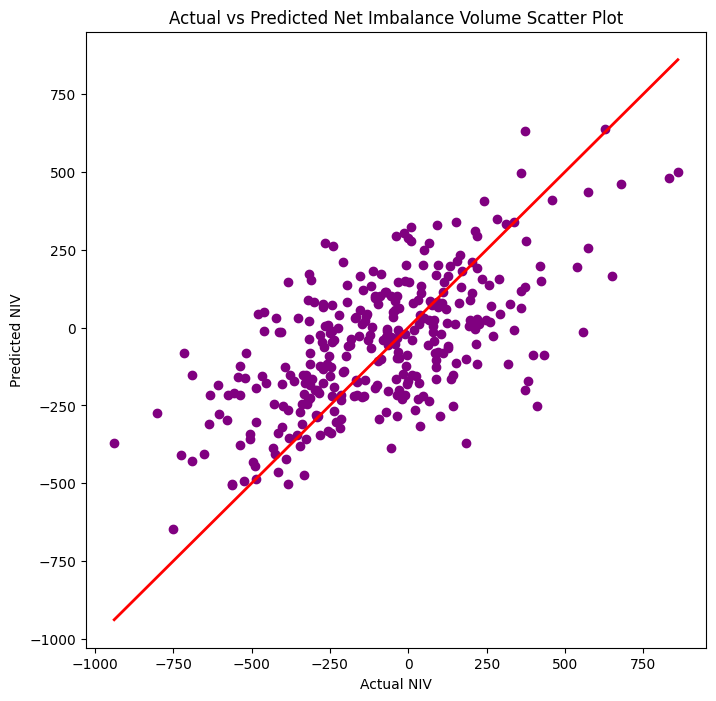

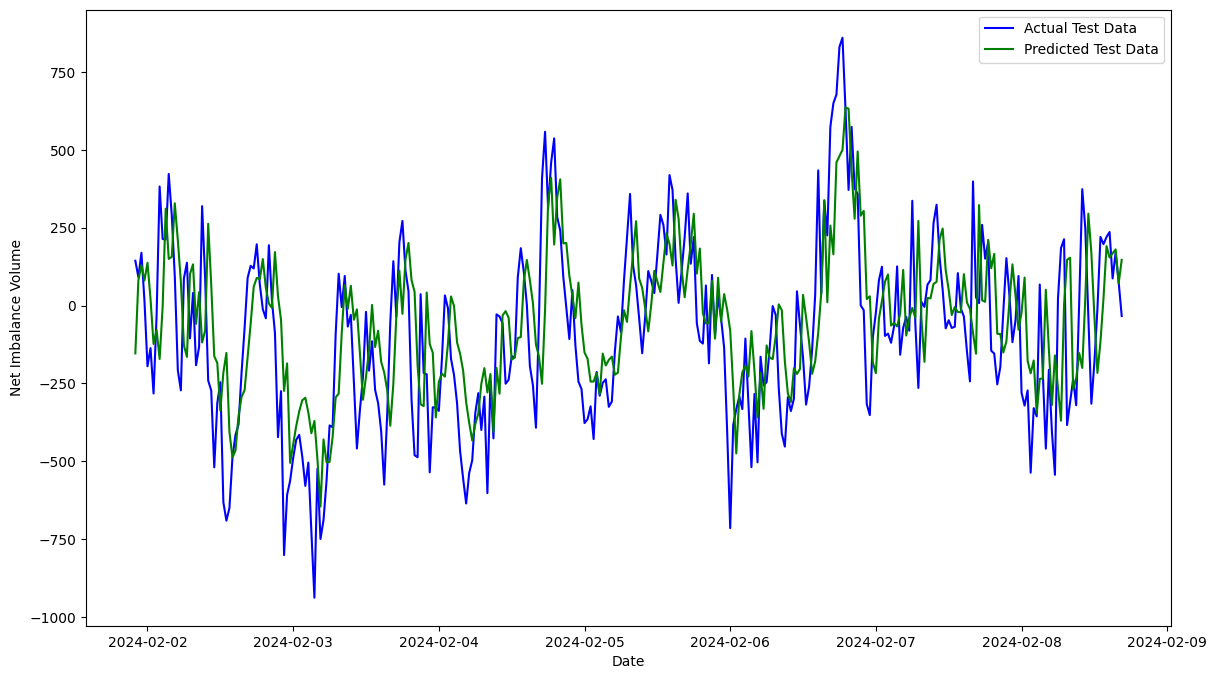

In [ ]:
test_scaled_data = scaler.transform(test_niv_data)
X_test, y_test = create_dataset(test_scaled_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

test_predictions = lstm_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

test_series_adjusted = test_data['NetImbalanceVolume'][time_step + 1:]

mse = mean_squared_error(test_series_adjusted, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_series_adjusted, test_predictions)
r2 = r2_score(test_series_adjusted, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

test_predictions_df = pd.DataFrame(test_predictions, index=test_series_adjusted.index, columns=['Predicted NIV'])

plt.figure(figsize=(8, 8))
plt.scatter(test_series_adjusted, test_predictions, color='purple')
plt.plot([test_series_adjusted.min(), test_series_adjusted.max()], [test_series_adjusted.min(), test_series_adjusted.max()], color='red', linewidth=2)
plt.xlabel('Actual NIV')
plt.ylabel('Predicted NIV')
plt.title('Actual vs Predicted Net Imbalance Volume Scatter Plot')
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(test_series_adjusted.index, test_series_adjusted, label='Actual Test Data', color='blue')
plt.plot(test_predictions_df.index, test_predictions_df['Predicted NIV'], label='Predicted Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('Net Imbalance Volume')
plt.legend()
plt.show()